<a href="https://colab.research.google.com/github/airesx2/cudaq/blob/main/quick-start-to-quantum/02_quick_start_to_quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quick start to Quantum Computing with CUDA-Q

# Lab 2 - Move onto Bigger and More Entangled Things: Programming with multiple qubits

## Overview

We'll continue to use the same template for creating a quantum program as in Lab 1:

* Encode information into the quantum state by initializing qubit(s)
* Manipulate the quantum state of the qubit(s) with quantum gate(s)
* Extract information from the quantum state by measuring the state of the qubit(s)

These three steps are outlined in the diagram below:

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/circuit.png" alt="image of a quantum circuit with the three partsL encode information, manipulate quantum states, extract information" width="200"/>

However, in this lab, in addition to programming with more than one qubit, we'll use this opportunity to demonstrate a practical programming practice of creating "subkernels" (similar to subroutines in a classical program) that can be reused and combined.  


**What you'll do:**

Through the interactive code blocks and exercises in this lab, you will

* Recognize allowable arguments accepted into a cudaq kernel function
* Apply a variety of single and multi-qubit gates to qubits using CUDA-Q and reason about the outcome of these operations
* Write quantum kernels that accept individual qubits or a register of qubits as arguments
* Write and apply kernels as subkernels (i.e., subroutines)
* Read and interpret quantum circuit diagrams
* Encode classical information (in particular, integers) into qubits using binary notation and the `x` gate

**Terminology you'll use:**

* Computational basis states (basis states for short)
* Probability amplitude
* Statevector
* (optional) Phase, relative phase, global phase
* Entanglement
* Interference
* Control and target for multi-qubit controlled-operations

**CUDA-Q syntax you'll use:**
* defining a quantum kernel: `@cudaq.kernel`,
* qubit initialization: `cudaq.qvector` and `cudaq.qubit`
* quantum gates: `x`, `h`, `y`, `z`, `t`, `s`, `swap`, and the `ctrl` method
* extracting information from a kernel: `get_state`, `get_state.amplitude()`, `sample`
* visualization tools: `add_to_bloch_sphere`, `show`, `draw`



Execute the cell below to load all the necessary packages for this lab.

In [3]:
# Instructions for Google Colab. You can ignore this cell if you have cuda-q and ipywidgets set up.
# Run this notebook in a CPU runtime
# Uncomment the lines below and execute the cell to install necessary packages.
!pip install cudaq
!pip install ipywidgets
!pip install matplotlib
!pip install qutip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 MB 7.5 MB/s eta 0:00:00
  Created wheel for cudaq: filename=cudaq-0.11.0-py3-none-any.whl size=6897 sha256=1488d05655fee18db50d06f96bd3326c6d2e1c22c94eb8666790c83be4c7932e
  Stored in directory: /root/.cache/pip/wheels/ad/0f/19/60352710d764963c7c1cb5d5f1ab78dc76e1b542899b33c35a
Successfully built cudaq
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Necessary packages

import cudaq
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import interactive_output, HBox, VBox

## 2.1 Program with more than one qubit


In this section, we'll create two quantum programs to illustrate the concepts of global phase and entanglement.  Additionally, these examples will allow us to demonstrate alternative ways of writing and combining multiple kernels &mdash; a useful technique to have on hand as our quantum algorithms grow in the number of qubits and the number of gate operations.  Both the number of qubits and the number of gate operations are limiting factors in the kind of quantum algorithms that can be run on current quantum hardware or simulated on GPUs.  In fact, we'll quickly see examples of quantum algorithms that we can program, but cannot implement with today's existing technology.



### 2.1.1 Notation for a 2-qubit state
$\renewcommand{\ket}[1]{|#1\rangle}$
In Lab 1, we saw that the quantum state of a single qubit could be written as linear combinations of the states $|0\rangle$ and $|1\rangle$.  The states $|0\rangle$ and $|1\rangle$ are often referred to as the computational basis states of a single qubit.  When we have 2 qubits, we will need $2^2 = 4$ basis states to describe all possible quantum states of 2 qubits because each qubit could be measured as either a $0$ or a $1$.  The computational basis states used to describe a state of 2 qubits are
$$\ket{00}, \ket{01}, \ket{10},  \text{ and }\ket{11}.$$

What does this notation mean? The expression $\ket{10}$ represents the state of a system of 2 qubits, (e.g., $q_0$ and $q_1$), where qubit $q_0$ is in the state $\ket{1}$ and $q_1$ is in the state $\ket{0}$.  In other words, the left most term (the $1$ in $\ket{10}$) corresponds to qubit $q_0$'s state and the rightmost term will be correspond to the state of the 2nd qubit.  Since there is no agreed upon standard ordering of qubits, this notational choice may differ from other quantum programming languages that you might run across.

The general form of a quantum state of 2 qubits, is a linear combination (or a superposition) of the computational basis states:

$$\ket{\psi} = \alpha_{00}\ket{00}+\alpha_{10}\ket{10}+\alpha_{01}\ket{01}+\alpha_{11}\ket{11},$$
where each coefficient (also called a **probability amplitude**) $\alpha_{ij}$ is a complex number and the sum of the probabilities corresponding to these coefficients is 1, that is: $$\sum_{i,j\in\{0,1\}} |\alpha_{ij}|^2 =1.$$  

Somtimes it is useful, albeit often less compact, to write the state $\ket{\psi}$ as a vector of probability amplitudes:
$$\ket{\psi} = \alpha_{00}\ket{00}+\alpha_{10}\ket{10}+\alpha_{01}\ket{01}+\alpha_{11}\ket{11}
 = \begin{pmatrix}\alpha_{00} \\ \alpha_{01} \\ \alpha_{10} \\ \alpha_{11}\end{pmatrix}$$

> **Note:** The ordering listed in the sum of the computational basis states $(00, 10, 01, 11)$ differs from the ordering in the vertical vector. We introduce both of these conventions because the ordering  $(00, 10, 01, 11)$ is used when we execute the `get_state` function, while the ordering in the vertical vector $(00, 01, 10, 11)$ is used in matrix and tensor algebra computations.

In the literature, the term **statevector** refers to a quantum state $\ket{\psi}$, but can also refer to the list of probability amplitudes of a quantum state $\ket{\psi}$.  



### 2.1.2 Write and interpret a 2-qubit quantum program

In this section, we'll write a program that builds upon the Bit-Flip and Hello World (minus state) programs from Lab 1.  In particular, our goal is to create one program with 2 qubits.  The first qubit will be initialized in the zero state, and we'll flip it to the one state.  The second qubit will be initialized in the minus state, and just for fun we'll apply the bit flip gate `x` to it too. The diagram represents the circuit for this program.

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/refs/heads/main/images/2-qubit-circuit.png" alt="quantum circuit diagram with 2 qubits" width="200"/>

In our example, qubit $q_0$, which starts in the $\ket{0}$ state undergoes a bit flip.  So we would expect, as we saw in Lab 1, that when the kernel is sampled in a noiseless setting, $q_0$ will be measured  $100\%$ of the time as a $\ket{1}$.   On the other hand, because qubit $q_1$ will be in a state of equal superposition, it will collapse to the $\ket{0}$ state approximately half of the time and will collapse to $\ket{1}$ the other times. Putting the information about the state of $q_0$ and $q_1$ together, we expect a $50\%$ probability of sampling a $\ket{10}$ and  $50\%$ probability of sampling a $\ket{11}$ when running the program depicted above.

The statevector of the 2-qubit system after the gates are applied, but  prior to measurement should be $$\ket{\psi} = -\frac{1}{\sqrt{2}}\ket{10} +\frac{1}{\sqrt{2}}\ket{11} = \begin{pmatrix}0 \\ 0 \\ -\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}} \end{pmatrix}$$

To understand the appearance of the minus sign in the equation above, refer to the optional section on phase later in this notebook.  For now, just notice that by squaring the absolute values of the amplitudes, we see a $50\%$ probability of sampling a $\ket{10}$ and  $50\%$ probability of sampling a $\ket{11}$.

We have several options for writing the CUDA-Q code to carry out the instructions above.  In the next subsections, we'll take a look at two options so that you can see some of the functionality of `cudaq.kernel`. In particular, we'll demonstrate
* how to pass individual qubits or a register of qubits to a kernel and
* how to use kernels as subkernels (subroutines).



#### 2.1.2.1 All-in-one kernel

We'll first code the quantum circuit like we did in Lab 1, by writing all the instructions sequentially in one kernel.

In [3]:
# Writing the all-in-one kernel

@cudaq.kernel
def all_in_one():
    """Creates a kernel with 2 qubits. The first qubit is initialized
    in the zero state, the second qubit is initialized in the minus state.
    An x gate is then applied to each qubit.
    """
    # Allocate 2 qubits (indexed by 0 and 1)
    qvector = cudaq.qvector(2) # By default these qubits are the zero state

    # Initialize qubit indexed with 1 as the minus state
    x(qvector[1])
    h(qvector[1])

    # Manipulate the quantum states by applying the bit flip gate (the `x` gate) to each qubit
    x(qvector) # We can apply a single-qubit gate to each qubit in a list of qubits

print(cudaq.draw(all_in_one))



     ╭───╮          
q0 : ┤ x ├──────────
     ├───┤╭───╮╭───╮
q1 : ┤ x ├┤ h ├┤ x ├
     ╰───╯╰───╯╰───╯



Let's check that this kernel generates our target state $\ket{\psi} = -\frac{1}{\sqrt{2}}\ket{10} +\frac{1}{\sqrt{2}}\ket{11}$ by using the `get_state` command.  We'll also use the `get_state.amplitudes` option to extract out the coefficients of the computational basis states $\ket{10}$ and $\ket{11}$ that are of interest to us.

In [4]:
# Compute the state of the system prior to measurement
all_in_one_state = cudaq.get_state(all_in_one)

# Return the amplitudes of |10> and |11>
all_in_one_amplitudes = all_in_one_state.amplitudes([[1,0], [1,1]])

# Print
precision = 4
print('All-in-one statevector array of coefficients:', np.round(np.array(all_in_one_state), precision))
print('All-in-one statevector: {} |10> + {} |11>'.format(np.round(all_in_one_amplitudes[0],precision), np.round(all_in_one_amplitudes[1],precision)))


All-in-one statevector array of coefficients: [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.7071+0.j]
All-in-one statevector: (-0.7071+0j) |10> + (0.7071+0j) |11>


> **Quick Tip:**

To remember the ordering of the coefficients in the statevector generated by the `get_state` command, it helps to recall the convention for associating numbers with their binary representations that places the least significant bit on the left.  For example, in a 2-bit system, we have the following translation between integers and bits:
$$\begin{matrix} \text{Integer} & \text{Binary representation}\\
& \text{least signinificant bit on left}\\
0 =\color{red}{0}*2^0+\color{blue}{0}*2^1 & \color{red}{0}\color{blue}{0} \\
1 = \color{red}{1}*2^0 + \color{blue}{0} *2^1 & \color{red}{1}\color{blue}{0}\\
2 = \color{red}{0}*2^0 + \color{blue}{1}*2^1 & \color{red}{0}\color{blue}{1} \\
3 = \color{red}{1}*2^0 + \color{blue}{1}*2^1 & \color{red}{1}\color{blue}{1} \end{matrix}
$$

> The `get_state` output generates a list of the coefficients in increasing order: $\ket{00}, \ket{10}, \ket{01}, \ket{11}$, corresponding to $0,1,2,3.$ To conveniently identify the coefficient for a given basis state, use the `get_state().amplitude()` command. For example, to extract the coefficient for the basis state $\ket{10}$, use `get_state(my_kernel).amplitude([1,0])`.  To retrieve the amplitudes of more than one state at a time, use the `amplitudes` option applied to a list of basis states, as demonstrated in the code block above.


#### 2.1.2.2 Kernels as subroutines

In this section, we will create the same quantum circuit as above, but this time we'll use kernels as subroutines. We'll create three separate kernels:

* `minus`, a kernel for the subroutine that initializes a given qubit as the minus state
* `xgate`, a kernel that applies the `x` gate to a list of qubits
* `nested_quantum_program`, a kernel to allocate the qubits and call the `minus` and `xgate` subroutines

Let's see how this is done. Take note of how we can pass qubits and lists of qubits to the kernel functions.

In [ ]:
# Defining three kernels to generate the example circuit

# Defining the subroutine, minus, as a kernel
@cudaq.kernel
def minus(qubit: cudaq.qubit):
    """When applied to a qubit in the zero state, generates the minus state
    Parameters
    ----------
    qubit : cudaq.qubit
        qubit upon which the kernel instructions will be applied
    """
    x(qubit)
    h(qubit)

# Defining the subroutine, xgate, as a kernel
@cudaq.kernel
def xgate(qubits: cudaq.qvector):
    """Applies an x-gate to each qubit in qubits
    Parameters
    ----------
    qubits : cudaq.qvector
        list of qubits upon which the kernel instructions will be applied
    """
    x(qubits)

# Allocating qubits and calling the subroutines defined above
@cudaq.kernel
def nested_quantum_program(num_qubits: int):
    """Creates a kernel with num_qubits-many qubits. The first qubit is initialized
    in the zero state, the second qubit is initialized in the minus state.
    An x gate is then applied to each qubit. Here num_qubits is at least 2.
    Parameters
    ----------
    num_qubits : int
        Number of qubits to be allocated
    """

    # Allocate num_qubits qubits indexed from 0 to num_qubits-1
    qvector = cudaq.qvector(num_qubits) # By default these qubits are in the zero state

    # Initialize the qubit indexed with 1 as the minus state
    # by calling the minus kernel acting on qvector[1]
    minus(qvector[1])

    # Manipulate the quantum states by applying the bit flip gate (the `x` gate) to each qubit
    # by calling the xgate kernel applied to a list of qubits
    xgate(qvector)


num_qubits = 2 # num_qubits should be an integer > 1

print(cudaq.draw(nested_quantum_program,num_qubits))



     ╭───╮          
q0 : ┤ x ├──────────
     ├───┤╭───╮╭───╮
q1 : ┤ x ├┤ h ├┤ x ├
     ╰───╯╰───╯╰───╯



**Exercise:** Edit the `##FIX_ME##` portion of the code block below that uses the `get_state.amplitudes` to verify that the `nested_quantum_program` generates the desired state $\ket{\psi} = -\frac{1}{\sqrt{2}}\ket{10}+\frac{1}{\sqrt{2}}\ket{11}$ when `num_qubits` is set to $2$.  

In [ ]:
# EXERCISE 1
num_qubits = 2

amplitudes = cudaq.get_state(nested_quantum_program, num_qubits)
print('|Psi>= {} |10> + {} |11>'.format(np.round(amplitudes[0],precision), np.round(amplitudes[1],precision)))

|Psi>= 0j |10> + 0j |11>


Now let's use the `sample` command to compare the two quantum programs. Notice the difference between the arguments in the `sample` command applied to the kernel `all_in_one` versus the
`sample` command applied to the kernel `nested_quantum_program` which takes as an argument `num_qubits`.

In [ ]:
# Compare the quasi-probability distributions of each kernel upon sampling
shots = 1000

# Sample the kernels
counts_all_in_one = cudaq.sample(all_in_one, shots_count=shots)
counts_nested = cudaq.sample(nested_quantum_program, num_qubits, shots_count=shots)


# Print
print('All-in-one sampling results:', counts_all_in_one)
print('Nested results:', counts_nested)

All-in-one sampling results: { 10:441 11:559 }

Nested results: { 10:513 11:487 }



> **Quick Tip:**
The `sample` command runs the kernel and takes a measurement `shots_count`-many times. The result of each kernel execution and measurement is a classical bitstring with the $i^{th}$ bit representing the measurement of the $i^{th}$ qubit. The result of the `sample` command is a `SampleResult` dictionary of the distribution of the bitstrings.  To create a more familiar `dict` Python type from your variable `myresult` of type `SampleResult`, use `asDict = {k:v for k,v in myresult.items()}`.


Before going on, let's interpret the output of the sample command.
Based on our prediction the output `{ 11:481 10:519 }` indicates that the first digit in the bitstrings `11` and `10` corresponds to qubit $q_0$, as it is `1` $100\%$ of the time, and the second digit corresponds to qubit $q_1$, which gets measured about half the time as a `0` and the other half of the time as a `1`.  



> **CUDA-Q Quick Tip:** The code blocks in this section demonstrate the ability for kernels to accept variables and to call one another.  It'll be useful to note:

> * CUDA-Q kernels can only accept variables of certain types.  In particular, you can pass an individual qubit (`cudaq:qubit`), a list of qubits (`cudaq:qview`), integers (`int`), floats (`float`), complex values (`complex`), and lists of integers (`list[int]`),floats (`list[float]`), and complex values (`list[complex]`).  The full list of allowable types can be found [here](https://nvidia.github.io/cuda-quantum/latest/specification/cudaq/kernels.html).
> * When sampling a kernel that accepts variables, the values for these variables, should appear in the `sample` function as a list following the kernel name, as seen in the example above where our kernel `nested_quantum_kernel` accepted an integer value `num_qubits`: `cudaq.sample(nested_quantum_program, num_qubits, shots_count=shots)`

**Exercise 2:**
Write a quantum program, using subkernels, to initialize three qubits in the zero state and place each qubit in the state $\ket{+}$ if it has even index and qubits with odd index should be placed in the $\ket{-}$ state (i.e., place $q_0$ and $q_2$ in the plus state and $q_1$ in the minus state.)  Use the `get_state` command to verify that your quantum program generates the desired quantum state. Print out the statevector to confirm. As a bonus, try making your program generic enough that it would work for any number of qubits.

For example, the state of a 3 qubit system prior to measurement should be:

\begin{aligned}\ket{\psi} &= \ket{+-+} \\ &= (\frac{1}{\sqrt{2}}(\ket{0}+\ket{1}))\otimes(\frac{1}{\sqrt{2}}(\ket{0}-\ket{1}))\otimes(\frac{1}{\sqrt{2}}(\ket{0}+\ket{1}) )\\ &= \frac{1}{\sqrt{8}}(\ket{000}+\ket{100}-\ket{010}-\ket{110}+\ket{101}+\ket{001}-\ket{011}-\ket{111}).\end{aligned}

The $\otimes$ notation above represents a tensor product. For now, you can treat this as a multiplication that satisfies standard multiplication properties such as transitivity and associativity. We will not be using this notation beyond this example. If you'd like a formal introduction to tensor products, check out [section 4.2.1 of this resource](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf).

> **CUDA-Q Quick Tip:** Inside a `cudaq.kernel` you can use python commands like `for` loops and `if` statements.  


In [ ]:
# EXERCISE 2

num_qubits = 3
shots = 1000

@cudaq.kernel
def alternating_signs(qubit_count: int):
    quibits = cudaq.qvector(qubit_count)
    curr = 0
    while curr < qubit_count:
      if curr % 2 == 0:
        h(quibits[curr])
        curr+=1
      else:
        x(quibits[curr])
        h(quibits[curr])
        curr+=1


# Draw the circuit
print(cudaq.draw(alternating_signs,num_qubits))

# Verify state
# Compute the state of the system prior to measurement
state = cudaq.get_state(alternating_signs, num_qubits)

# Print
precision = 4
print('Statevector array of coefficients:', np.round(np.array(state), precision))

     ╭───╮     
q0 : ┤ h ├─────
     ├───┤╭───╮
q1 : ┤ x ├┤ h ├
     ├───┤╰───╯
q2 : ┤ h ├─────
     ╰───╯     

Statevector array of coefficients: [ 0.3536+0.j  0.3536+0.j -0.3536+0.j -0.3536+0.j  0.3536+0.j  0.3536+0.j
 -0.3536+0.j -0.3536+0.j]


#### 2.1.1.3 Phase (optional)

Phase is a characteristic of quantum states that we have not yet discussed. Estimating the phase of a given quantum state is an important step in many quantum algorithms including Shor's algorithm.  Additionally, phase helps explain the phenomena of **interference** which is key in algorithms such as Grover's.    

Every state has a phase factor.  The **phase factor** of a state can be deduced from the term $e^{i\varphi}$ in the standard representation of a quantum state: $$
\ket{\psi} = \cos(\frac{\theta}{2})\ket{0}+\sin(\frac{\theta}{2})e^{i\varphi}\ket{1}. $$

We are often interested when two states have different phases.  This can happen in one of two ways: differing by a global phase or by a relative phase.  We've seen examples of both of these already in Lab 1 and in the previous examples in this lab.  

Let's take a deeper look at qubit $q_1$ in the `nested_quantum_program` example from the previous section.  We can follow the state of $q_1$ as it changes throughout the kernel execution. We begin in the state $\ket{0}$ which is flipped to $\ket{1}$. Then, an application of the $H$ gate takes us to $\ket{-} = \frac{1}{\sqrt{2}}\ket{0}-\frac{1}{\sqrt{2}}\ket{1}$.  This is followed by an application of the bit flip operator $X=\begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix}$.  Carrying out this matrix multiplication we get that the state of $q_1$ prior to the measurement is:
$$ X\ket{-}=\begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix}\begin{pmatrix} \frac{1}{\sqrt{2}} \\ -\frac{1}{\sqrt{2}}\end{pmatrix}
= \begin{pmatrix} -\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{pmatrix} = -\ket{-}.
$$

When we measure $ -\ket{-}$ we get a similar quasi-probability distribution that we would get if we measured  $\ket{-}$.  We saw this behavior in Lab 1, where $\ket{+}$ and $\ket{-}$ had indistinguishable quasi-probability distributions upon measurement with `mz`.  However, if we measured the states $\ket{+}$ and $\ket{-}$ with `mx` we could distinguish the two states through their quasi-probability distributions.  Unlike in Lab 1, there is no measurement that we can apply to $\ket{-}$ and $-\ket{-}$ to distinguish them.

The state $\ket{-}$ and $-\ket{-}$ only differ by a scalar multiple of $-1$.  When states only differ by a factor of $-1$, they are said to differ by a **global phase**.  And these states cannot be distinguished from one another through any measurements, so they are often treated as being equivalent, or interchangeable.

This is in contrast to the states $$\ket{+} =  \frac{1}{\sqrt{2}}\ket{0}+\frac{1}{\sqrt{2}}\ket{1}=\frac{1}{\sqrt{2}}\ket{0}+e^{i*0}\frac{1}{\sqrt{2}}\ket{1}$$ and $$\ket{-}=  \frac{1}{\sqrt{2}}\ket{0}-\frac{1}{\sqrt{2}}\ket{1}=\frac{1}{\sqrt{2}}\ket{0}+e^{i\pi}\frac{1}{\sqrt{2}}\ket{1},$$ which have equal amplitudes but differ by a **relative phase**, in this case $\pi$.  

In general the **relative phase** difference between two states
$$
\ket{\psi_1} = \cos(\frac{\theta}{2})\ket{0}+\sin(\frac{\theta}{2})e^{i\varphi_1}\ket{1} $$
and  
$$
\ket{\psi_2} = \cos(\frac{\theta}{2})\ket{0}+\sin(\frac{\theta}{2})e^{i\varphi_2}\ket{1} $$
is defined to as $\varphi := |\varphi_1-\varphi_2|$

**Question:** What is the relative phase difference between $\ket{+}$ and $\ket{i}$?



### 2.1.2 Write a "Hello, Entangled World!" program

So far, all of the quantum operations (e.g. `x`, `h`) that we programmed acted only on an individual qubit.  In this section, we'll write a program using multi-qubit gates.  Let's start with the example of the controlled-not gate, often abbreviated the `CNOT` gate. This is a gate that operates on 2 or more qubits. One of the qubits is considered the "target", and the remaining qubits are the "control".  For instance `CNOT([q0,q1],q2)` would represent a gate with control qubits in the list `[q0,q1]` and target qubit `q2`.  

In a circuit diagram we depict the `CNOT` gate as a line connecting the control and target qubits with a $\bigoplus$ located at the target qubit and a solid circle on control qubits. For instance, in the circuit diagram below, we see a `CNOT(q0, q1)` and a `CNOT([q1,q2],q0)` gate.

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/refs/heads/main/images/cnots.png" alt="quantum circuit diagram with various cnot gates" width="200"/>

The rough idea is that if the "control" qubits are all in the state $\ket{1}$ then an application of the `CNOT` gate will apply a bitflip (i.e. an `x` gate) to the target qubit.  If on the other hand, at least one of the "control" qubits is in the $\ket{0}$ state the `CNOT` gate has no effect.

To illustrate this, let's code up a few examples.

> **Quick Tip:**
The syntax for the CNOT gate is `x.ctrl(control_qubit, target_qubit)` if we have only one control qubit.  When we have multiple control qubits, we send them as a list to the `x.ctrl` function: `x.ctrl(control_qubits_list, target_qubit)`.

In [2]:
# CNOT applied to the states |00>, |01>, |10>, |11>
#If the first is on, the second gets CNOT gated
print('In this example CNOT is applied with the control qubit q0 and the target q1.')

@cudaq.kernel
def apply_cnot(control: cudaq.qubit, target: cudaq.qubit):
    """Apply an CNOT gate to the control and target qubits"""
    x.ctrl(control, target)

@cudaq.kernel
def initialize(qubits: cudaq.qview, state: list[int]):
    """Kernel to initialize the state indicated by the given list
    0: |0>, 1: |1>"""
    for idx in range(len(state)):
        if state[idx] == 1:
            x(qubits[idx])

@cudaq.kernel
def CNOT_example(state: list[int]):
    """Apply CNOT to the state given by the state numbers"""
    qubits = cudaq.qvector(len(state))
    # Initialize state
    initialize(qubits, state)
    # Apply CNOT to the first two bits
    if len(state) > 1:
        apply_cnot(qubits[0], qubits[1])

# Test computational basis states
for i in range(4):
    bits = format(i,'b')
    bit_list = [int(bit) for bit in bits.zfill(2)]
    result = cudaq.sample(CNOT_example, bit_list).most_probable()
    print(f'CNOT applied to the state |{bits.zfill(2)}> results in |{result}>')



In this example CNOT is applied with the control qubit q0 and the target q1.
CNOT applied to the state |00> results in |00>
CNOT applied to the state |01> results in |01>
CNOT applied to the state |10> results in |11>
CNOT applied to the state |11> results in |10>


While the previous examples showed CNOT operations on basis states (|0⟩ and |1⟩), the interactive tool below lets you explore more interesting quantum behaviors. Try selecting superposition states (|+⟩ or |-⟩) for either or both qubits to see how the CNOT gate functions. You'll discover some surprising quantum behaviors that have no classical counterpart!

In [ ]:
# Exceute this cell to generate an interactive visualization of the CNOT gate
import sys
sys.path.append('interactive_widget')
from CNOT_visualization import create_CNOT_widget

# Create and display a new widget
widget = create_CNOT_widget()
display(widget)


**Exercise 3 Part a:** Edit the code block below to see the effect of the gate sequence in the diagram below on the qubits if $q_0$ was initialized as $\ket{+}$ and $q_1$ was initialized as $\ket{1}$

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/exercise3a.png" alt="image of a circuit with 3 alternating cnots and q_0 initialized as |+> and q_1 initialized as |1>" width="200"/>

In [2]:

# EXERCISE 3 Part a
@cudaq.kernel
def alternating_cnots(qubit0: cudaq.qubit, qubit1: cudaq.qubit):
    """Apply a sequence of 3 CNOTs with alternating controls and targets on the 2 qubits given as arguments"""
    # We will see later that it doesn't matter which qubit you start out with as the first control, as long as
    # you alternate the control and target qubits with each of the 3 applications of the cnot gate

    # Edit code below this line
    x.ctrl(qubit0, qubit1) #1st CNOT
    x.ctrl(qubit1, qubit0) #2nd CNOT
    x.ctrl(qubit0, qubit1) #3rd CNOT
    # Edit code above this line


@cudaq.kernel
def three_alternating_cnots():
    """Kernel for the circuit drawn above"""

    # Allocate qubits
    q = cudaq.qvector(2)

    # Initialize qubits q0 and q1 in the plus and one states, respectively
    h(q[0])
    x(q[1])

    # Apply alternating CNOTs
    alternating_cnots(q[0], q[1])



results = cudaq.sample(three_alternating_cnots)
print('The distribution of states after sampling is: {}'.format(results))


The distribution of states after sampling is: { 10:513 11:487 }



Did you notice that the `alternating_cnots` kernel had the effect of swapping the states of $q_0$ and $q_1$?  This is a useful operation, so there is a dedicated notation for it.  We refer to this gate sequence as the `SWAP` gate, and abbreviate the gate sequence as a line with 2 Xs on the endpoints connecting the qubits:  


<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/SWAP.png" alt="image of a circuit with a swap gate and one of three alternating cnots" width="200"/>

The CUDA-Q command for a SWAP gate applied to qubits $q_0$ and $q_1$ is `swap(q_0, q_1)`. Let's use CUDA-Q to check that the `swap` gate has the same effect on two qubits as the `alternating_cnots` kernel.

In [3]:
# Verify that the SWAP and alternating_cnots have the same effect on the state |+1>

@cudaq.kernel
def applying_swap():
    """Kernel for the circuit drawn above"""

    # Allocate qubits
    q = cudaq.qvector(2)

    # Initialize qubits q0 and q1 in the plus and one states, respectively
    h(q[0])
    x(q[1])

    # Apply alternating CNOTs
    swap(q[0], q[1])

results = cudaq.sample(three_alternating_cnots)
print('The distribution of states after sampling is: {}'.format(results))

The distribution of states after sampling is: { 10:482 11:518 }



Now, let's explore another example that will showcase one of the powerful computations achievable with quantum gates.

**Exercise 3 Part b:** Edit the ##FIX_ME## phrase in the code block below to apply the `x.ctrl` gate to the state $\ket{+0}$.

In [4]:
# EXERCISE 3 Part b

@cudaq.kernel
def apply_cnot(control: cudaq.qubit, target: cudaq.qubit):
    """Apply an CNOT gate to the control and target qubits"""
    x.ctrl(control, target)

@cudaq.kernel
def initialize_plus_zero(qubits: cudaq.qview):
    """Kernel to initialize the state indicated by the given list of bits"""
    # Place qubits[0] in the plus state
    h(qubits[0])

@cudaq.kernel
def CNOT_exercise():
    """Apply CNOT to |+0> with control q0 and target q1"""
    qubits =cudaq.qvector(2)
    # Initialize state
    initialize_plus_zero(qubits)
    # Apply CNOT to the first two bits
    apply_cnot(qubits[0], qubits[1])

results = cudaq.sample(CNOT_exercise)
print('CNOT applied to the state |+0> results in the distribution of states: {}'.format(results))


CNOT applied to the state |+0> results in the distribution of states: { 00:491 11:509 }



To understand the output of the exercise above, let's use the ket notation.  First we should point out that one characteristic of quantum gates that we've not mentioned explicitly is linearity.  For example, if we have a gate $U$ applied to the state $\ket{\psi}=\alpha\ket{0}+\beta\ket{1}$, we can understand the action of $U$ on $\ket{\psi}$ by knowing how $U$ affects $\ket{0}$ and $\ket{1}$.  In particular, we can distribute $U$ across the terms of $\ket{\psi}$:
$$ U\ket{\psi} = U(\alpha\ket{0}+\beta\ket{1}) =  U(\alpha\ket{0}) +  U(\beta\ket{1})=\alpha U\ket{0} + \beta U\ket{1}.$$
This generalizes beyond one-qubit gates to multi-qubit gates.

Therefore, when we apply the `CNOT` to $\ket{+0} = \frac{1}{\sqrt{2}}\ket{00}+ \frac{1}{\sqrt{2}}\ket{10}$ we get

$$CNOT\ket{+0} = CNOT(\frac{1}{\sqrt{2}}\ket{00}+ \frac{1}{\sqrt{2}}\ket{10})=\frac{1}{\sqrt{2}}CNOT\ket{00} + \frac{1}{\sqrt{2}}CNOT\ket{10} = \frac{1}{\sqrt{2}}\ket{00} +  \frac{1}{\sqrt{2}}\ket{11}.$$

### 2.1.3 Multi-qubit gates as matrices

To understand why gate operations are linear, it helps to represent a multi-qubit gate as a matrix, just as we have done in Lab 1 for single qubit gates.
For example the matrix for the CNOT gate using the convention of CUDA-Q ordering is:
$$CNOT = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}.
$$

Using the fact that  $\ket{+0} = \frac{1}{\sqrt{2}}\ket{00}+ \frac{1}{\sqrt{2}}\ket{10}$, we can verify our work from the previous section:

$$ CNOT\ket{+0} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}(\frac{1}{\sqrt{2}}\ket{00}+ \frac{1}{\sqrt{2}}\ket{10})
=  \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}
\begin{pmatrix} \frac{1}{\sqrt{2}}  \\ 0 \\ \frac{1}{\sqrt{2}} \\ 0\end{pmatrix} =
\begin{pmatrix} \frac{1}{\sqrt{2}} \\ 0 \\ 0 \\ \frac{1}{\sqrt{2}}  \end{pmatrix} =
 \frac{1}{\sqrt{2}}\ket{00} +  \frac{1}{\sqrt{2}}\ket{11}
$$

The state $\frac{1}{\sqrt{2}}\ket{00} +  \frac{1}{\sqrt{2}}\ket{11}$ is an example of entanglement.  Along with superposition, this property helps to distinguish quantum algorithms from classical.  Let's take a look at this property next.

> **FAQ:** If quantum states can be represented as vectors, and quantum gates can be realized through matrix operations, then why do we need quantum computers if we can theoretically simulate any quantum circuit through matrix multiplication classically?

> **Answer:**  One thing to note is that as the number of qubits increases, the number of possible states increases exponentially and the size of the matrix representing the multi-qubit gate also increases exponentially.  For instance, a 3-qubit system (like the Exercise 4 in the next section) can be in one of $2^3 = 8$ states, and the size of the matrix representing a 3-qubit gate is $8\times 8$.  This suggests that straightforward attempts at using matrix multiplication to simulate quantum computation on CPUs fail for circuits with only 30 or so qubits.  With CUDA-Q's platform and GPU-accelerated built-in simulators, it is possible to simulate larger systems. That said, there may one day be a fault tolerant quantum computer that can carry out computations too big for even the largest classical supercomputers.




### 2.1.4 Entanglement

Entanglement of two (or more) qubits is akin to the concept of dependence in linear algebra.  That is to say that two qubits are entangled if the state of one of the qubits depends on the other.  Formally the definition of entanglement relies on tensor products, which are beyond the scope of this Quick Start series of notebooks.  You can read more about tensor products and the precise definition of entanglement [here](http://mermin.lassp.cornell.edu/qcomp/CS483.html) or [here](https://qubit.guide).  For now, we'll illustrate entanglement through the example of the 2-qubit state
$$ \ket{\psi} =\frac{1}{\sqrt{2}}\ket{00} +  \frac{1}{\sqrt{2}}\ket{11}.$$

The state $\ket{\psi}$ has equal probability of being measured in the state $\ket{00}$ or $\ket{11}$.  Let's look at what happens if we measure the first qubit.

* If our system of two qubits is in the state $\ket{\psi}$ and we measure qubit 0 to be $0$, then the state of the system collapses to $\ket{00}$.  In this case, without taking a measurement on qubit 1, we already know its state (it's $\ket{0}$).  

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/bell0.png" alt="image of a circuit for the Bell State with the first qubit measured to be a 0" width="200"/>

* Similarly if the state of our system is $\ket{\psi}$ and qubit 0 is measured to be 1, then  the state of the system collapses to $\ket{11}$.  Although prior to any measurement on qubit 0, qubit 1 had a $50\%$ probability of being in state $\ket{0}$ or $\ket{1}$, after measuring qubit 0 to be 1, we know that qubit 1 must be in the state $\ket{1}$.

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/bell1.png" alt="image of a circuit for the Bell State with the first qubit measured to be a 1" width="200"/>


So we see that even though prior to measurement, both qubits 0 and 1 have equal probabilities of being measured a 0 or 1, once we measure one of these qubits, the outcome of the other qubit has been determined and depends on the state of the qubit that was measured.  In other words,  qubit 0 and qubit 1 are **entangled**.



**EXERCISE 4:**
Edit the code block below to create a quantum program with 3 qubits to:
* Initialize the state  $\ket{\psi} = \ket{+-+} = \frac{1}{\sqrt{8}}(\ket{000}+\ket{100}-\ket{010}-\ket{110}+\ket{101}+\ket{001}-\ket{011}-\ket{111})$ by editing the ##FIX_ME##
* Apply a `x.ctrl` gate with control qubit $q_0$ and target $q_1$.  Then apply a Hadamard gate to $q_1$.
* Sample the result


In [2]:
# EXERCISE 4
num_qubits = 3

@cudaq.kernel
def initial_state(qubits : cudaq.qview):
    for index in range(len(qubits)):
        if index % 2 !=0:
            x(qubits[index])
    h(qubits)

@cudaq.kernel
def interference(qubit_count: int):
    qvector = cudaq.qvector(qubit_count)

    initial_state(qvector) # Initialize the state

    # Apply x.ctrl with control q_0 and target q_1. Then apply a Hadamard gate to q_1.
    # Edit the code below this line
    x.ctrl(qvector[0], qvector[1])
    h(qvector[1])

    # Edit the code above this line

results = cudaq.sample(interference, num_qubits, shots_count = 1000)
print(results)

{ 010:259 011:248 110:265 111:228 }



**Question**: What do you notice about the probability amplitudes in Exercise 4?  Pay specific attention to the probability amplitude for
$\ket{110}$, $\ket{011}$, $\ket{111}$, and $\ket{010}$ compared to those of of the other basis states.

The changing of the probability amplitudes in this exercise is an example of interference, which we'll discuss next.

### 2.1.5 Interference

In a quantum program, we apply gates to change quantum state from one state to another.  In effect, what we're doing is changing the probability amplitudes associated with each of the basis states.  This process is called **interference**.  Interference is central in almost every quantum algorithm.

We can have both constructive and destructive interference.  Like the classical interference of waves from raindrops on the surface of a puddle, constructive interference occurs when the probability amplitude of basis state is increased, and destructive interference occurs when the probability of a basis state decreases due to the action of quantum gates.  The previous example demonstrates both constructive and deconstructive interference. The circuit is initialized in a state having equal magnitude probability amplitudes, but after applying the CNOT gate and Hadamard gate, the probabilities of measuring $\ket{110}$, $\ket{011}$, $\ket{111}$, and $\ket{010}$ have each been amplified, while the probabiliy amplitudes associated with the other basis states have been reduced to $0$.



## 2.3 Other multi-qubit gates

There are many more quantum gates than the handful that we've explicitly used so far.  In the previous lab, we mentioned that any rotation of the Bloch sphere corresponds to a quantum gate on one qubit. So in theory, there are an infinite number of possible quantum gates: one for each of the possible rotations of the sphere.  In this section, we'll first detail what these rotations gates look like both as matrices and as CUDA-Q operations. Then  we'll use these rotations gates to define a larger class of multi-qubit controlled gates.


### 2.3.2 Revisiting single-qubit rotation gates

We've already seen the `x`-gate that rotates a state around the x-axis of the Bloch sphere by 180 degrees and the Hadamard gate which rotates the Bloch sphere 180 degrees about a different axis causing $\ket{0}$ to move to $\ket{+}$ and $\ket{1}$ to rotate to $\ket{-}$, and vice versa.  But how do we implement gates for other angles of rotation, or different axis of rotation?  One easy answer is to use some of the gate operations built into CUDA-Q.  These include the `y`-gate for 180 degree rotation about the $y$-axis and the `z`-gate for 180 degree rotation about the $z$ axis.  The `t` and `s` gates correspond to other fixed angle rotations about the $z$ axis.  

**EXERCISE 5:** Experiment with applying the `t` and `s` gates to various states in the code block below to deduce the rotation angle for the `t` and `s` gates and to predict the relationship between the `t` and `s` gates.

In [ ]:
# EXERCISE 5
# Run this cell to generate an interactive visualization of the T and S gates
# Change the initial state of the qubit to see how the T and S gates affect the state

import sys
sys.path.append('interactive_widget')
from t_and_s_gate import create_t_and_s_widget

# Create and display a new widget
widget = create_t_and_s_widget()
display(widget)

To access arbitrary angle rotations about the $x$, $y$, and $z$ axis of the Bloch sphere, we can use the `rx`, `ry`, and `rz` commands.

In the code block, we plot the effect of rx on the state $\ket{0}$ for a variety of angles.  You can see that when the angle is $\pi$, the rotation gate `rx` is equivalent to the `x` gate.  Feel free to edit the code bloch to apply the `ry` or `rz` gates to various angles on different intial states.  

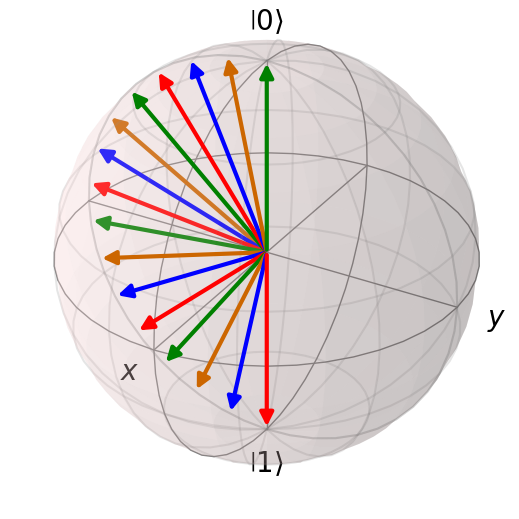

In [3]:
import qutip
# set the number of angles to plot
num_angles = 15

@cudaq.kernel
def rotate_x(angle : float):
    qubit = cudaq.qubit()

    # Apply the unitary transformation
    # Rx(θ) = |  cos(θ/2)  -isin(θ/2) |
    #         | -isin(θ/2)  cos(θ/2)  |
    rx(angle, qubit)


blochSphere = qutip.Bloch()
for n in range(num_angles+1):
    theta = np.pi*n/num_angles
    sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(rotate_x, theta), blochSphere)

# Display the Bloch spheres side by side in 2 rows and 2 columns
cudaq.show(blochSphere)




### 2.3.3 Controlled gates

Earlier we examined the CNOT gate (`x.ctrl`) which is a controlled-x gate.  That is, the `x` gate is applied conditionally on the state of one or more of the control qubits.  Similarly, we can create controlled gates for any of our single qubit gates using the `.ctrl` suffix.  For instance `t.ctrl` will apply a `t` gate conditionally on the the state of the control qubit.



With just a few of these gates, we can carry out some interesting computations.  Let's check out one step of Shor's algorithm in the next section.

## 2.4 Application: modular arithmetic


Shor's algorithm is a well-known example that has the potential to break RSA encryption, assuming it could be executed on a fault-tolerant quantum computer at a sufficiently large scale. While we won’t be implementing the full algorithm here (you can explore more details [here starting on page 341](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf), [Chapter 4 of these lecture notes](https://arxiv.org/pdf/2311.08445)  or [chapter 3 of Mermin's book here](http://mermin.lassp.cornell.edu/qcomp/CS483.html) and you can view the code for Shor's algorithm [here](https://nvidia.github.io/cuda-quantum/latest/applications/python/shors.html)), we will focus on one step of the algorithm: performing modular arithmetic. This will serve as a demonstration of the concepts we've covered so far and offer an opportunity to encode classical information (in this case, an integer) onto qubits.
The circuit shown below, inspired by [this article](https://physlab.org/wp-content/uploads/2023/05/Shor_s_Algorithm_23100113_Fin.pdf), performs the operation of multiplying $5y$ modulo $21$, with the initial state representing various values of $y = 1, 4, 5, 16, 17, 20$.

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/modular_circuit.png" alt="circuit for computing 5y mod 21 for certain values of y" width="200"/>

 For instance, if we want to calculate $5 \times 1 \mod 21$, we would encode $y = 1$ by preparing the quantum state $\ket{10000}$ through the application of an $X$ gate to qubit $q_0$:

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/modular_circuit_y_equals_1.png" alt="circuit for computing 5y mod 21 for certain values of y" width="200"/>



**EXERCISE 6:** Edit the code below to carry out the instructions of the circuit diagrams above to compute $5*y\mod{21}$ and verify that the outcome of the circuit is as expected.  For example, when the circuit is initialized as $y = 20$, we should expect to sample the binary representation of 16 (which is `00001`) since $5*20 = 100 \equiv 16\mod{21}$.

In [35]:
# EXERCISE 6
#Had a lot of trouble with modular_mult_5_21
#

import random

@cudaq.kernel
def modular_mult_5_21(qubits : cudaq.qvector):
    """"Kernel based off of the circuit diagram in
    https://physlab.org/wp-content/uploads/2023/05/Shor_s_Algorithm_23100113_Fin.pdf
    Modifications were made to change the ordering of the qubits.
    """
    # Edit code below this line
    #Claud AI
    x.ctrl(qubits[4], qubits[0])
    x.ctrl(qubits[2], qubits[0])
    x(qubits[4])
    x(qubits[2])
    x.ctrl(qubits[0], qubits[4])
    x.ctrl(qubits[0], qubits[2])
    # Edit code above this line

@cudaq.kernel
def encode_integer(qubits: cudaq.qvector, binary_rep: list[int]):
    """Kernel takes as input a list of qubits and the binary representation
    of an integer as a list. The kernel adds X-gates to the qubits to encode
    the binary list, placing an X gate on qubit i if there is a 1 in the ith location
    on the binary_rep list"""
    # Edit code below this line
    for i in range(len(binary_rep)):
      if binary_rep[i] == 1:
        x(qubits[i])


    # Edit code above this line


def decimal_to_binary_list(number):
    # Check if the input number is valid (non-negative integer)
    if number < 0:
        raise ValueError("Number must be a non-negative integer.")

    # Convert the number to binary using bin() function and strip the '0b' prefix
    binary_string = bin(number)[2:]

    # Convert the binary string to a list of integers (0s and 1s)
    binary_list = [int(bit) for bit in binary_string]

    return binary_list

@cudaq.kernel
def mult_y_by_5_mod21(binary_list: list[int]):

    # Allocate qubits
    qubits = cudaq.qvector(5)

    # Initialize qubits in the state representing 1, 4, 5, 16, 17, or 20
    encode_integer(qubits, binary_list)
    # Apply the multiplication by 5 mod 21 kernel
    modular_mult_5_21(qubits)

values = [1,4,5,16, 17, 20]
number = random.choice(values) # selects a number from the list values randomly
# Convert number into a binary representation stored as a list of 0s and 1s
binary_list = decimal_to_binary_list(number)

results = cudaq.sample(mult_y_by_5_mod21, binary_list, shots_count = 200)
print("Multiplying {} by 5 mod 21 results in the bitstring {}".format(number,results.most_probable()))


Multiplying 20 by 5 mod 21 results in the bitstring 00001


**Exercise 7:** Create a kernel that carries out modular exponentiation 5^x mod 21 using the `mult_y_by_5_mod21` of the previous exercise. Hint: $5^6 \mod(21) = 1$.  


In [27]:
# EXERCISE 7
#Based on flawed solution of exercise 6

@cudaq.kernel
def modular_exp_kernel(exponent: int):
    """Kernel computes 5^x mod 21
    Parameters:
    -----------
    exponent : int
        the value x for the computation 5^x mod 21

    Returns:
    --------
    binary_rep : string
        binary representation for 5^x mod 21 as a string of 0s and 1s
    """
    # Allocate and intialize qubits
    qubits = cudaq.qvector(5)

    # Edit code below this line

    # Encode y = 1
    encode_integer(qubits, [0, 0, 0, 0, 1])

    # Multiply y = 1 by 5 exp times
    for _ in range(exponent):
        modular_mult_5_21(qubits)

    # Edit code above this line


def modular_exp(exponent: int):
    sample_result = cudaq.sample(modular_exp_kernel, exponent, shots_count = 100).most_probable()
    return sample_result

for x in range(0,7):
    result = modular_exp(x)

    print("5^{} mod 21 in binary representation is {}".format(x, result))

5^0 mod 21 in binary representation is 00001
5^1 mod 21 in binary representation is 01101
5^2 mod 21 in binary representation is 00100
5^3 mod 21 in binary representation is 10101
5^4 mod 21 in binary representation is 11000
5^5 mod 21 in binary representation is 11101
5^6 mod 21 in binary representation is 00101


## 2.5 Next

While [Shor's algorithm for factoring numbers](https://nvidia.github.io/cuda-quantum/latest/applications/python/shors.html) is one of the most famous quantum computing algorithms, it is not considered a (Near-term Intermediate Scale Quantum) NISQ-era program since it requires more qubits, with less noise, than currently available.  There are, however, several NISQ-era programs that can be run on current quantum hardware and simulated with GPUs.  Many of these programs are based on variational algorithms, which we'll explore in the next lab.